In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explorative Data Analysis 

## Read Data

In [234]:
data = pd.read_csv("HY_Universe_corporate bond.csv")
print("There are", data.shape[0], "observations and", data.shape[1], "features in this dataset.")
print("From a rule of thumb, the sample complexity (#observations / #features) is about", round(data.shape[0]/data.shape[1]), 
      "which is greater than 20. Sample size is enough and we could try to use as many features as possible.")

There are 2721 observations and 37 features in this dataset.
From a rule of thumb, the sample complexity (#observations / #features) is about 74 which is greater than 20. Sample size is enough and we could try to use as many features as possible.


## Feature Description
- `CUSIP`: unique id of bond.
- `Ticker`: unknown categorical data with large size.
- `Issue Date` / `Maturity`: the date when bonds were made (pay off).
- `1st Call Date`: the earliest date issuer could pay off the bond.
- `Moodys`/`S&P`/`Fitch`/`Bloomberg`: rating of bond (categorical). Apply ordinal encoding
- `Coupon`: discrete (continuous?). There are mistakes of scale(unit).
- `Issued Amount`
- `Maturity Type`: Categorical data with samll size. Should check the consistency with 1st Call Date. Apply one-hot encoding.
- `Coupon Type`: Categorical data with samll size.
- `Maturity At Issue months`: a continuous feature refers to the length of time until a bond reaches maturity. 
- `Industry`: company's industry. Apply one-hot encoding.
- `LiquidityScore`: a continuous feature measures how easily the bond can be bought or sold in the market
- `Months in JNK`: number of months that particular bond is in JNK etf pool.
- `Months in HYG`: number of months that particular bond is in HYG etf pool.
- `Months in Both`: should check the consistency with previous two features.
- `IN_ETF`: whether the bond has been in etf pool. Should check the consistency with previous three features.
- `LIQ SCORE`: liquidity score, the same as LiquidityScore. (at different scale, check the consystency and could drop one).
- `n_trades`: number of trades during life time.
- `volume_trades`: total number of shares been traded.
- `total_median_size`/`total_mean_size`: the median/mean volume of a single trade.
- `n_days_trade`: the number of days that bond had trades. Propotional to liquidity score. Should check the consistency.
- `days_diff_max`: maximum interval where no trades happened.
- `percent_intra_dealer`: percent of trades that happened between two dealers, rather than between a dealer and an end investor.
- `percent_uncapped`: percentage of a bond's trading volume that is not subject to a predetermined maximum limit. A measure of liqudity.
- `bond_type`: categorical data with small size, apply one-hot encoding.
- `Client_Trade_Percentage`: unknow continuous features scale to [0, 1]. 
- `weekly_mean_volume`/`weekly_median_volume`/`weekly_max_volume`/`weekly_min_volume`/`weekly_mean_ntrades`/`weekly_median_ntrades`: are measures of volume and trades in week level.

## 

## Check the Correctness of Data

### Maturity Type and 1st Call Date
Callable bond could have 1st call date, other tpyes do not.

In [235]:
print("Bond types are as follows: ", data['Maturity Type'].unique())

Bond types are as follows:  ['CALLABLE' 'AT MATURITY' 'CALL/SINK' 'PERP/CALL' 'CALL/EXT' 'EXTENDIBLE'
 'SINKABLE' 'SINK/EXT' 'PUTABLE' 'CALL/REF/SINK' 'NORMAL' 'CALL/PUT']


In [236]:
# Maturity Type and 1st Call Date are good. No non-callale bond have call date.
condition1 = data['Maturity Type'] != "CALLABLE"
condition2 = data["1st Call Date"] != "Nan"
data.loc[condition1 & condition2, 'Maturity Type'].unique()

array(['PERP/CALL', 'CALL/SINK', 'CALL/EXT'], dtype=object)

### LiquidityScore and LIQ SCORE

In [237]:
data["LiquidityScore"]

0       10.891365
1       24.625486
2       12.841557
3       26.226355
4       14.138395
          ...    
2716    16.047078
2717    13.633019
2718    11.920145
2719    11.589039
2720    18.350672
Name: LiquidityScore, Length: 2721, dtype: float64

In [238]:
# LiquidityScore = LIQ SCORE * 100
print("Total difference of LiquidityScore and LIQ SCORE for", data.shape[0], "samples are:", 
      sum(np.abs(data["LiquidityScore"]/100 - data['LIQ SCORE'])))

# Thus, drop LiquidityScore
data = data.drop(columns = "LiquidityScore")

Total difference of LiquidityScore and LIQ SCORE for 2721 samples are: 6.706200022174591e-07


### LiquidityScore and percent_uncapped
Check the relation of `LIQ SCORE` and `percent_uncapped` to make sure my understand of `percent_uncapped` is correct. <br>
From the following plot, we can tell that `percent_uncapped` is an indicator positively correlated to liquidity.

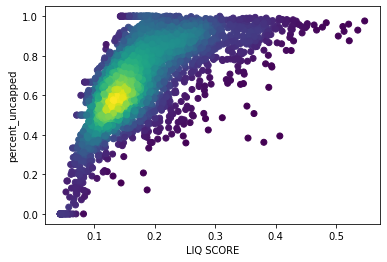

In [239]:
from scipy.stats import gaussian_kde
xy = np.vstack([data["LIQ SCORE"], data["percent_uncapped"]])
z = gaussian_kde(xy)(xy)
plt.scatter(data["LIQ SCORE"], data["percent_uncapped"], c=z)
plt.xlabel("LIQ SCORE")
plt.ylabel("percent_uncapped")
plt.show()

### ETF Related Features

1. `Months in Both` should be smaller than or equal to the minimum of `Months in JNK` and `Months in HYG`
2. `IN_ETF` is Yes if minimum of `Months in JNK` and `Months in HYG` > 0

In [240]:
# Convert Months in Both from string to integer
data.loc[data['Months in Both']=="Nan", "Months in Both"] = "0"
data.loc[data['Months in JNK']=="Nan", "Months in JNK"] = "0"
data.loc[data['Months in HYG']=="Nan", "Months in HYG"] = "0"
data["Months in Both"] = data["Months in Both"].astype(int)
data["Months in JNK"] = data["Months in JNK"].astype(int)
data["Months in HYG"] = data["Months in HYG"].astype(int)

# `Months in Both` should be smaller than or equal to the minimum of `Months in JNK` and `Months in HYG`
condition1 = data.loc[:, ["Months in JNK", "Months in HYG"]].min(axis = 1) >= data["Months in Both"]

# `IN_ETF` is Yes
condition2 = data["IN_ETF"] == "Yes"

# At lease in one of pool
condition3 = data.loc[:, ["Months in JNK", "Months in HYG"]].max(axis = 1) != 0


data.loc[~condition1, ["Months in JNK", "Months in HYG", "Months in Both"]]

Empty DataFrame
Columns: [Months in JNK, Months in HYG, Months in Both]
Index: []

In [241]:
# Check whether condition2 and condition3 are not matched
data.loc[condition2 != condition3, ["Months in JNK", "Months in HYG", "IN_ETF"]]

Empty DataFrame
Columns: [Months in JNK, Months in HYG, IN_ETF]
Index: []

From results above, ETF related features are consistent.

### Coupon

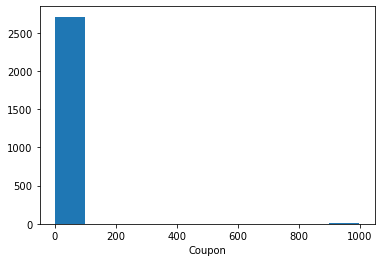

In [242]:
plt.hist(data["Coupon"])
plt.xlabel("Coupon")
plt.show()

The distribution of coupon should not look like this. There are some extreme values.

In [243]:
data.loc[data['Coupon']>50]

CUSIP Ticker Issue Date                  Maturity 1st Call Date  \
393   038521AG5   ARMK  8/22/2007                  2/1/2015           Nan   
435   03969AAF7  ARGID   7/3/2014                12/15/2019           Nan   
439   03969AAK6  ARGID  5/16/2016                 5/15/2021           Nan   
723   085790AP8   BERY  6/10/2008                 2/15/2015           Nan   
955   126650BK5    CVS  5/25/2007                  6/1/2037           Nan   
1022  140661AJ8   BGRP  9/30/2011                 9/30/2014           Nan   
1023  140661AK5   BGRP  9/30/2011                 9/30/2015           Nan   
1061  151290BD4  CEMEX   4/5/2011                 9/30/2015           Nan   
1419  225448AB5     CS  5/15/2007  Nan Field Not Applicable           Nan   
1547  251528AA3     DB  5/18/1999  Nan Field Not Applicable           Nan   
2241  524908WZ9    LEH  5/17/2007  Nan Field Not Applicable    10/23/2017   

     Moodys S_and_P Fitch Bloomberg Composite Rating  Coupon  ...  \
393      WR      NR    WD                         NR   999.0  ...   
435      WR      NR   Nan                         NR   999.0  ...   
439      WR      NR   Nan                         NR   999.0  ...   
723      WR      NR   Nan                         NR   999.0  ...   
955      WR      NR    WD                         NR   999.0  ...   
1022    Nan     Nan   Nan                        Nan   999.0  ...   
1023    Nan     Nan   Nan                        Nan   999.0  ...   
1061    Nan      NR    WD                         NR   999.0  ...   
1419     WR      NR    WD                         NR   999.0  ...   
1547     WR      NR    WD                         NR   999.0  ...   
2241     WR      NR   Nan                         NR   999.0  ...   

      percent_intra_dealer percent_uncapped bond_type  \
393               0.201571         0.583770         5   
435               0.124046         0.521947         5   
439               0.161826         0.468880         5   
723               0.201426         0.458111         5   
955               0.367325         1.000000         5   
1022              0.079208         0.356436         5   
1023              0.196970         0.509091         5   
1061              0.000000         0.300000         5   
1419              0.070175         0.421053         5   
1547              0.428571         0.214286         5   
2241              0.380952         0.714286         5   

      Client_Trade_Percentage weekly_mean_volume  weekly_median_volume  \
393                  0.340314       2.816663e+06             2000000.0   
435                  0.426527       5.864616e+06             4960000.0   
439                  0.443983       3.658255e+06             2400000.0   
723                  0.390374       3.947301e+06             3190000.0   
955                  0.382675       8.194727e+05              414000.0   
1022                 0.495050       8.257408e+06             4499500.0   
1023                 0.409091       5.899694e+06             3270000.0   
1061                 0.637500       2.072147e+06             1650000.0   
1419                 0.473684       2.043053e+06             1000000.0   
1547                 0.428571       2.265400e+06             1109000.0   
2241                 0.523810       1.243750e+06              915000.0   

      weekly_max_volume  weekly_min_volume weekly_mean_ntrades  \
393          21500000.0            9000.00            4.292135   
435          18250000.0           85945.95            7.820896   
439          39720000.0          200000.00            4.725490   
723          19170000.0           40000.00            5.446602   
955          10017000.0           18000.00           16.581818   
1022         52932000.0           80000.00           11.222222   
1023         34148000.0           18534.00            8.461538   
1061          6000000.0          300000.00            2.352941   
1419         13600000.0            1000.00            3.000000   
1547          7000000.

We have no further information to fix the error and sample size is large enough. Thus, we choose to drop those observations.

In [244]:
data = data[data['Coupon']<50]

### Maturity and Maturity at Issue Month
There are some NaN values in maturity. First we check whether `Maturity At Issue months` matched with `Issue Date` and `Maturity`. If so, we could use two to compute and refill the NaN values.

In [245]:
print("There are", data["Maturity At Issue months"].isna().sum(), "NaN value in Maturity At Issue months.")

There are 0 NaN value in Maturity At Issue months.


In [246]:
# Maturity is a string type
print("There are", (data["Maturity"] == "Nan Field Not Applicable").sum(), "NaN values in Maturity")


There are 83 NaN values in Maturity


In [247]:
# Check match
date_data = data.loc[data["Maturity"] != "Nan Field Not Applicable", ["Issue Date", "Maturity", "Maturity At Issue months"]]
date_data

Issue Date    Maturity  Maturity At Issue months
0       7/1/2014    7/1/2019                     60.87
1      3/15/2004    6/4/2018                    173.13
2      5/14/2010   3/15/2015                     58.87
3      6/17/2013   4/30/2020                     83.63
4     12/22/2016  12/15/2024                     97.17
...          ...         ...                       ...
2716   4/18/2017   1/15/2027                    118.63
2717   3/14/2007  12/15/2025                    228.37
2718   7/25/2006   8/15/2016                    122.47
2719    8/5/2014   8/15/2024                    122.10
2720   7/21/2015   8/15/2024                    110.43

[2627 rows x 3 columns]

In [248]:
date_data["Issue Date"] = pd.to_datetime(date_data.loc[:, "Issue Date", ])
date_data["Maturity"] = pd.to_datetime(date_data.loc[:, "Maturity", ])

In [249]:
# (maturity date(days) - issue date(days)) / 30 (per month) - Maturity At Issue months, 
# then divided by Maturity At Issue months to compute the errors in percentage.
errors = np.abs((date_data["Maturity"] - date_data["Issue Date"])/np.timedelta64(1, 'M') -
                date_data["Maturity At Issue months"])/date_data["Maturity At Issue months"]

print("Maximum error is " + str(round(errors.max()*100,2))+"%.")

Maximum error is 1.46%.


Maximum error is 1. 46%, which is accurate, considering rounding of feature `Maturity At Issue months`. 

In [250]:
data["Issue Date"] = pd.to_datetime(data.loc[:, "Issue Date"])
# Observations where maturity is NaN
condition1 = data["Maturity"] == "Nan Field Not Applicable"

In [265]:
# Selection the observations and assign computed values
data.loc[condition1, "Maturity"] = \
(data.loc[condition1, "Issue Date"] + np.timedelta64(1, 'M') * data.loc[condition1, "Maturity At Issue months"]).dt.date
# Check computation is correct
data.loc[condition1, ["Issue Date", "Maturity", "Maturity At Issue months"]].head()

Issue Date    Maturity  Maturity At Issue months
84  2000-02-07  2030-12-08                    370.03
304 2014-11-10  2019-12-11                     61.03
305 2015-03-02  2020-04-10                     61.33
495 2016-06-15  2026-08-07                    121.73
529 2007-02-16  2017-12-05                    129.63

### General View of Issued Amount

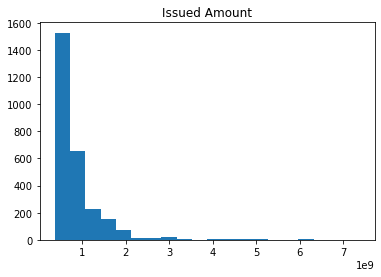

In [292]:
plt.hist(data["Issued Amount"], bins=20)
plt.title("Issued Amount")
plt.show()

### General View of difference of median and mean
From the plot, we could see that generally the distribtuion is not skew heavily since median and mean are close. However, there are rare cases when median is significantly smaller than mean. (Most of data are placed in right half of the axis)

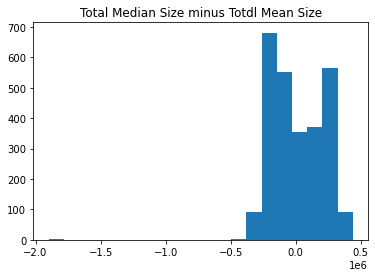

In [291]:
plt.hist(data['total_median_size'] - data['total_mean_size'], bins=20)
plt.title("Total Median Size minus Totdl Mean Size")
plt.show()

In [286]:
# Up to now, it seems harmless. Keep an eye on this observation. 
data[(data['total_median_size'] - data['total_mean_size']) < -1000000]

CUSIP Ticker Issue Date   Maturity 1st Call Date Moodys S_and_P  \
2142  500630BQ0    KDB 2009-01-23  1/23/2014           Nan     WR      NR   

     Fitch Bloomberg Composite Rating  Coupon  ...  percent_intra_dealer  \
2142    NR                         NR     8.0  ...                   0.4   

     percent_uncapped bond_type  Client_Trade_Percentage weekly_mean_volume  \
2142              0.6         5                      0.4          5375000.0   

      weekly_median_volume  weekly_max_volume  weekly_min_volume  \
2142             5375000.0          5750000.0          5000000.0   

     weekly_mean_ntrades  weekly_median_ntrades  
2142                 2.5                      1  

[1 rows x 36 columns]

### Check all percentage data are in range of (0, 1)

In [301]:
np.sum(
    (data.loc[:, ["percent_intra_dealer", "percent_uncapped", "Client_Trade_Percentage"]] > 1) | \
    (data.loc[:, ["percent_intra_dealer", "percent_uncapped", "Client_Trade_Percentage"]] < 0)
)

percent_intra_dealer       0
percent_uncapped           0
Client_Trade_Percentage    0
dtype: int64

## Visualization of Data